In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

# Spread rate choice

The goal of the notebook is to explore different ways to compute a spread rate of the COVID-19 for a given country using the cumulative time series of confirmed cases.

This spread rate will then be used to compare the evolution of the COVID-19 in different countries with the position, climate and urbanization of the countries.

## Plotting confirmed cases

Before choosing between different spread rate computation methods, let's plot the cumulative time series of confirmed cases for a few countries to visualize the tendency and the shape of the curves.

In [2]:
data = pd.read_csv('data/data.csv')
data = data.drop(columns=['Latitude', 'Longitude', 'Urban Population', 'Total Population', 'Mortality Rate', 'Mean temperature', 'Climate'])

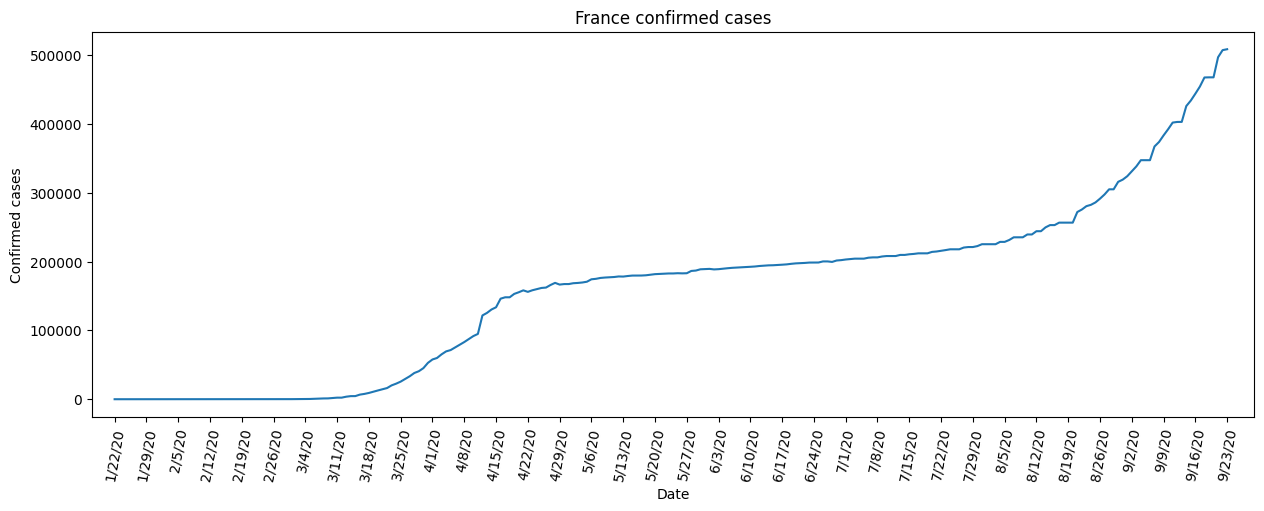

In [39]:
country = 'France'

country_data = data[data['Country'] == country]
country_data = country_data.drop(columns=['Country'])

x = country_data.columns
y = country_data.values[0]

plt.figure(figsize=(15, 5))
plt.plot(x, y)
plt.title(f'{country} confirmed cases')
plt.xlim(-5, len(x) + 5)
plt.xlabel('Date')
plt.ylabel('Confirmed cases')
plt.xticks(rotation=80)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(7))
plt.show()

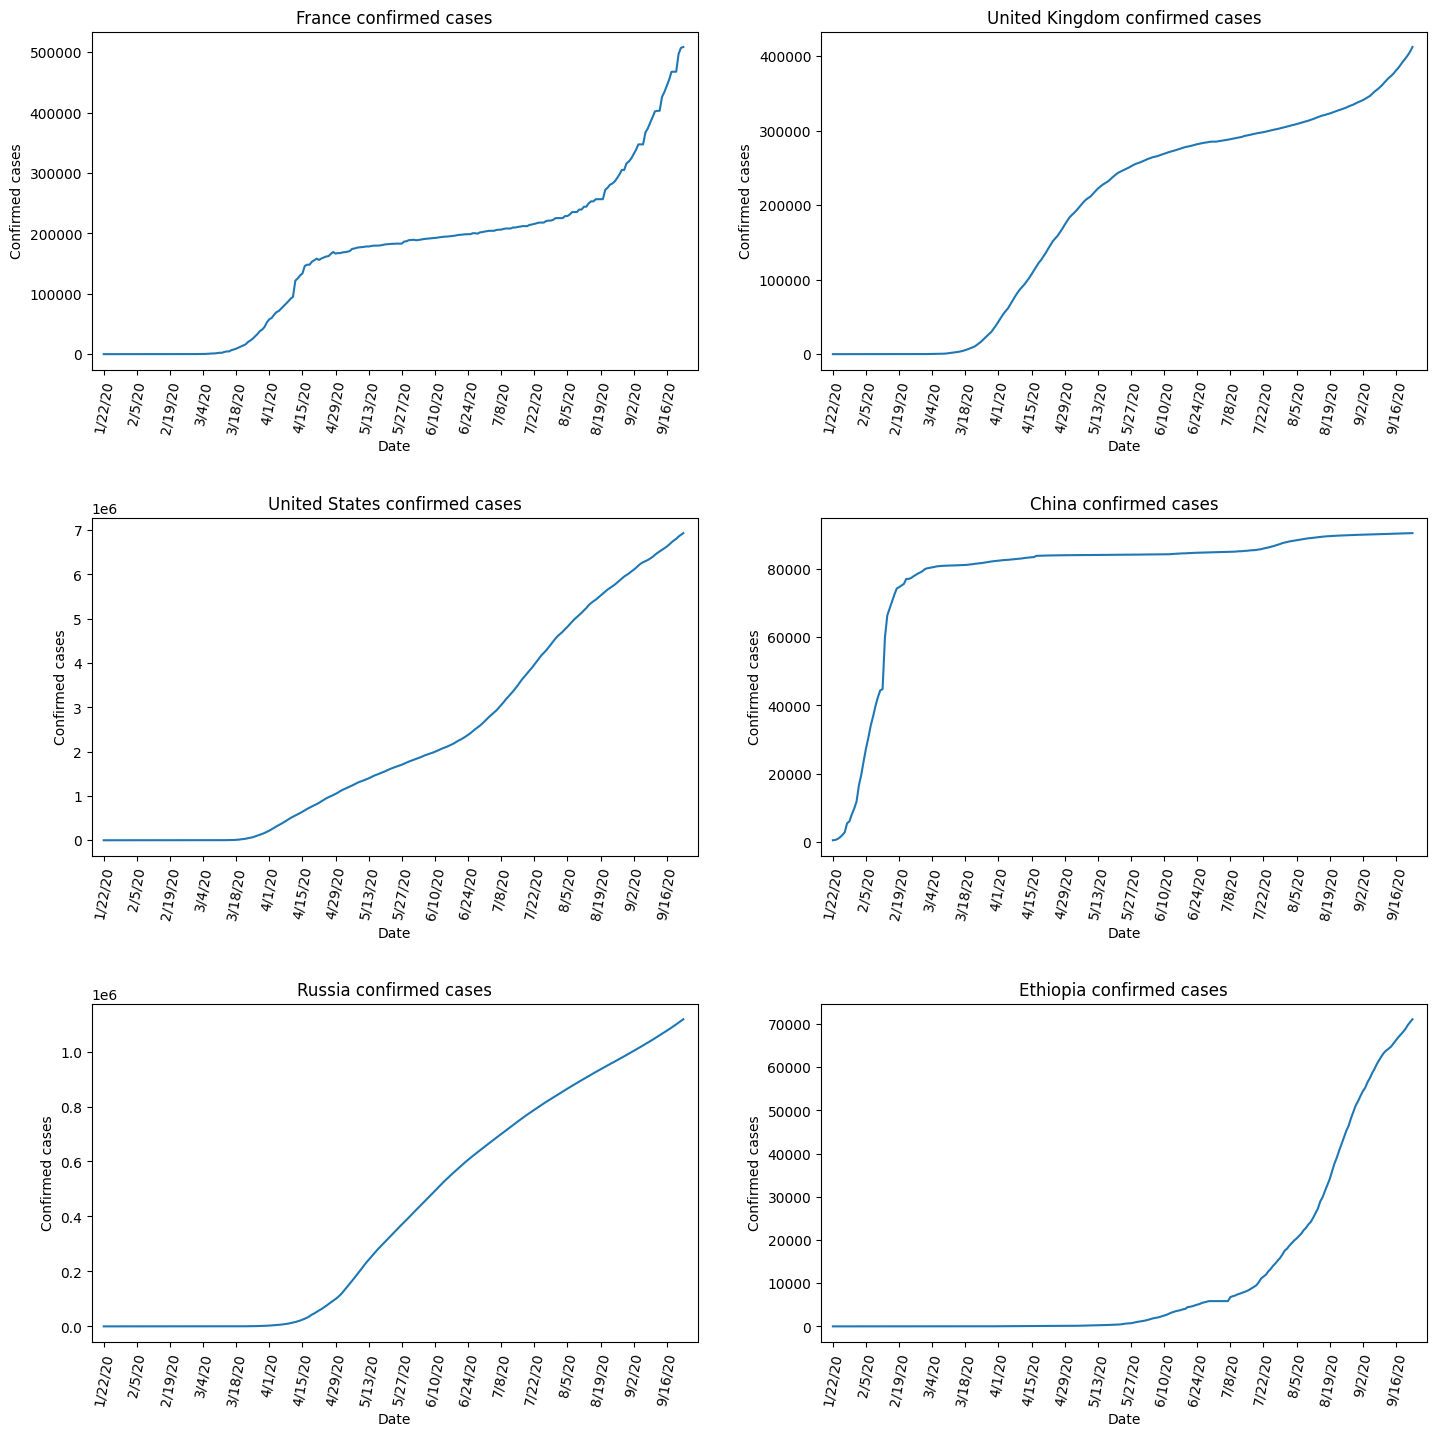

In [40]:
countries = ['France', 'United Kingdom', 'United States', 'China', 'Russia', 'Ethiopia']

n = len(countries)
fig, axs = plt.subplots(math.ceil(n/2), 2, figsize=(15, 5 * math.ceil(n/2)))
for i, country in enumerate(countries):
    country_data = data[data['Country'] == country]
    country_data = country_data.drop(columns=['Country'])

    x = country_data.columns
    y = country_data.values[0]

    axs[i//2, i%2].plot(x, y)
    axs[i//2, i%2].set_title(f'{country} confirmed cases')
    axs[i//2, i%2].set_xlim(-5, len(x) + 5)
    axs[i//2, i%2].set_xlabel('Date')
    axs[i//2, i%2].set_ylabel('Confirmed cases')
    axs[i//2, i%2].tick_params(axis='x', rotation=80)
    axs[i//2, i%2].xaxis.set_major_locator(plt.MultipleLocator(14))
fig.tight_layout(pad=3.0)
plt.show()

We can see that the curves have very different shapes, some are linear, some are exponential, some have several phases. This is why it is important to choose a spread rate computation method that is robust to these different shapes.

## Exploring spread rate computation methods

We'll explore the following spread rate computation methods:
- Linear regression
- Exponential regression
- Time to double cases
- Daily reproduction number

### Linear regression
In this part, we'll fit a curve of the form $y = ax + b$ to the cumulative time series of confirmed cases. The slope of the linear regression will be the spread rate.

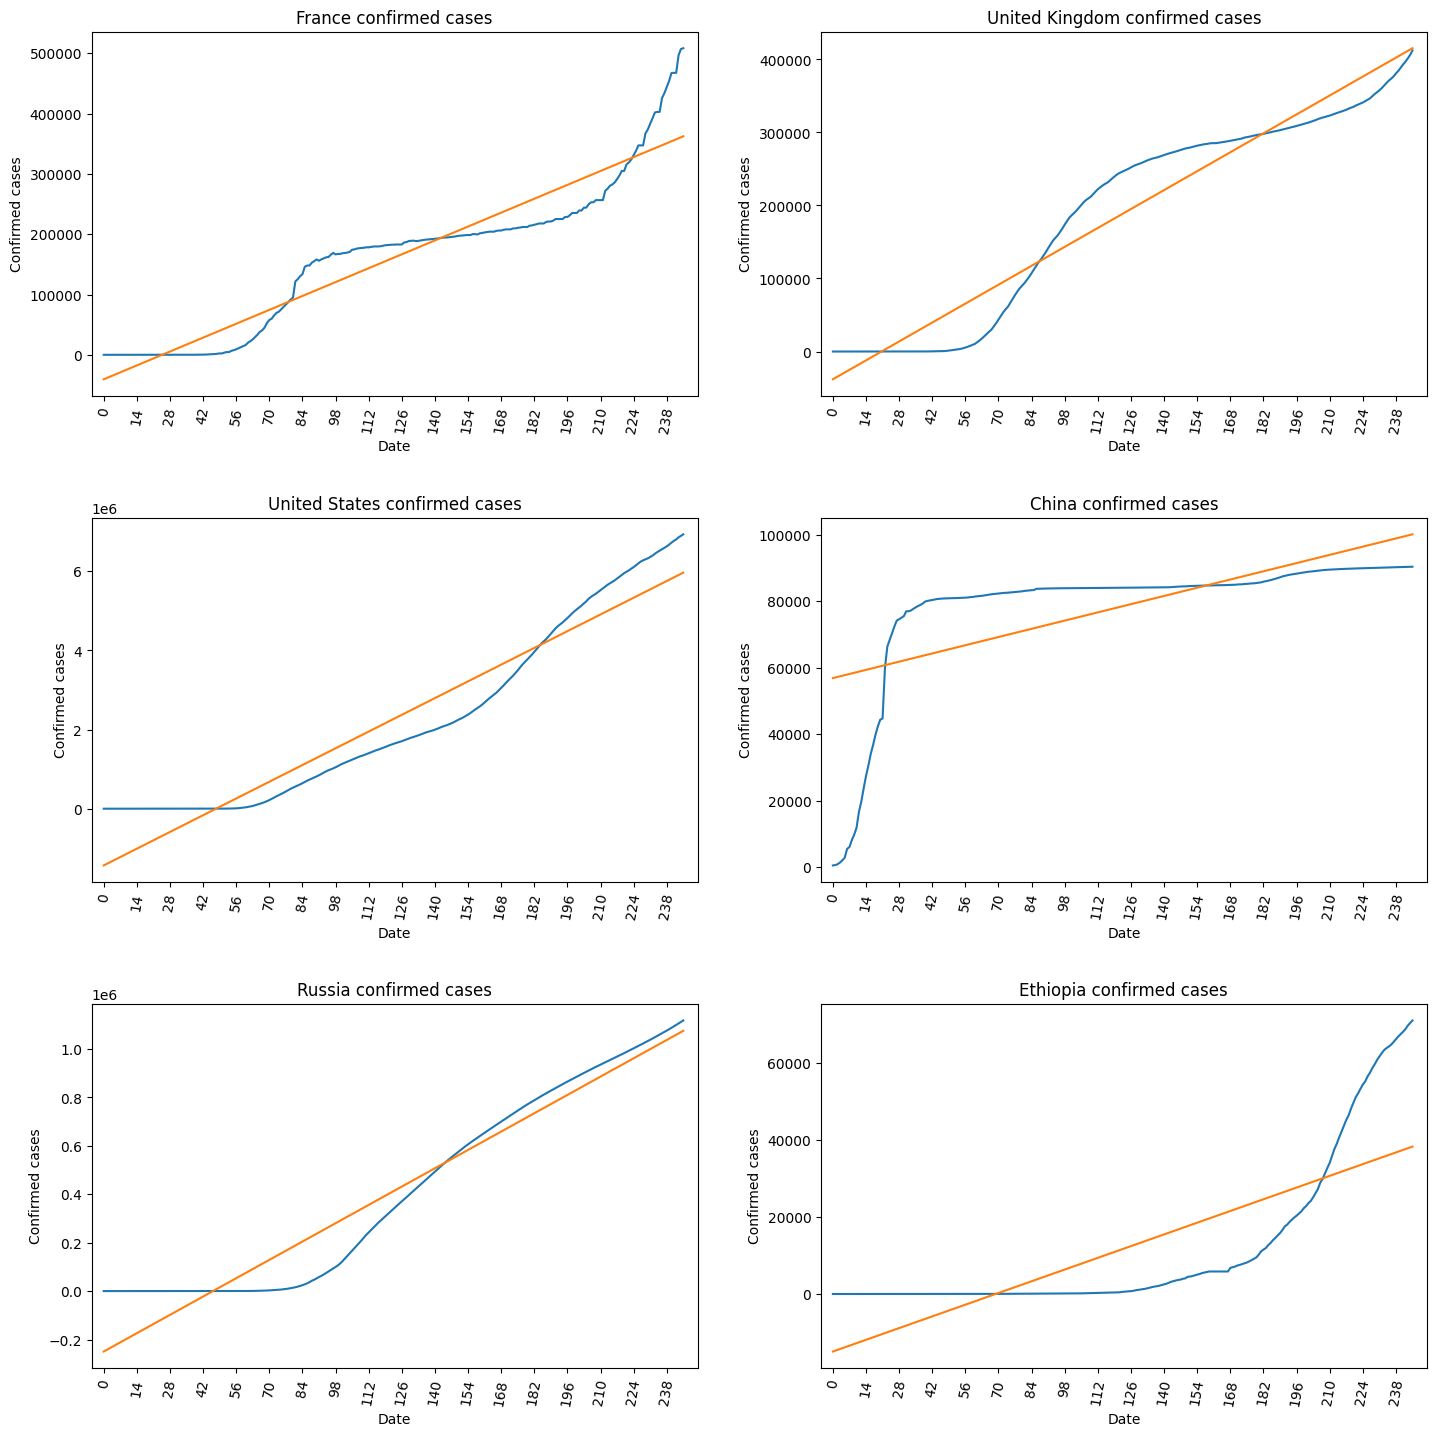

In [41]:
from sklearn.linear_model import LinearRegression


countries = ['France', 'United Kingdom', 'United States', 'China', 'Russia', 'Ethiopia']

n = len(countries)
fig, axs = plt.subplots(math.ceil(n/2), 2, figsize=(15, 5 * math.ceil(n/2)))

for i, country in enumerate(countries):
    country_data = data[data['Country'] == country]
    country_data = country_data.drop(columns=['Country'])

    x = range(len(country_data.columns))
    y = country_data.values[0]

    model = LinearRegression()
    model.fit([[i] for i in x], y)

    axs[i//2, i%2].plot(x, y)
    axs[i//2, i%2].plot(x, model.predict([[i] for i in x]))
    axs[i//2, i%2].set_title(f'{country} confirmed cases')
    axs[i//2, i%2].set_xlim(-5, len(x) + 5)
    axs[i//2, i%2].set_xlabel('Date')
    axs[i//2, i%2].set_ylabel('Confirmed cases')
    axs[i//2, i%2].tick_params(axis='x', rotation=80)
    axs[i//2, i%2].xaxis.set_major_locator(plt.MultipleLocator(14))
fig.tight_layout(pad=3.0)
plt.show()

As we could have expected, the linear regression fits well for countries like Russia and USA that have a linear growth of confirmed cases. However, it is a terrible fit for Ethiopia whose curve looks more like an exponential.

### Exponential regression
In this part, we'll fit a curve of the form $y = \exp(ax + b)$ to the cumulative time series of confirmed cases. The slope of the exponential regression will be the spread rate.

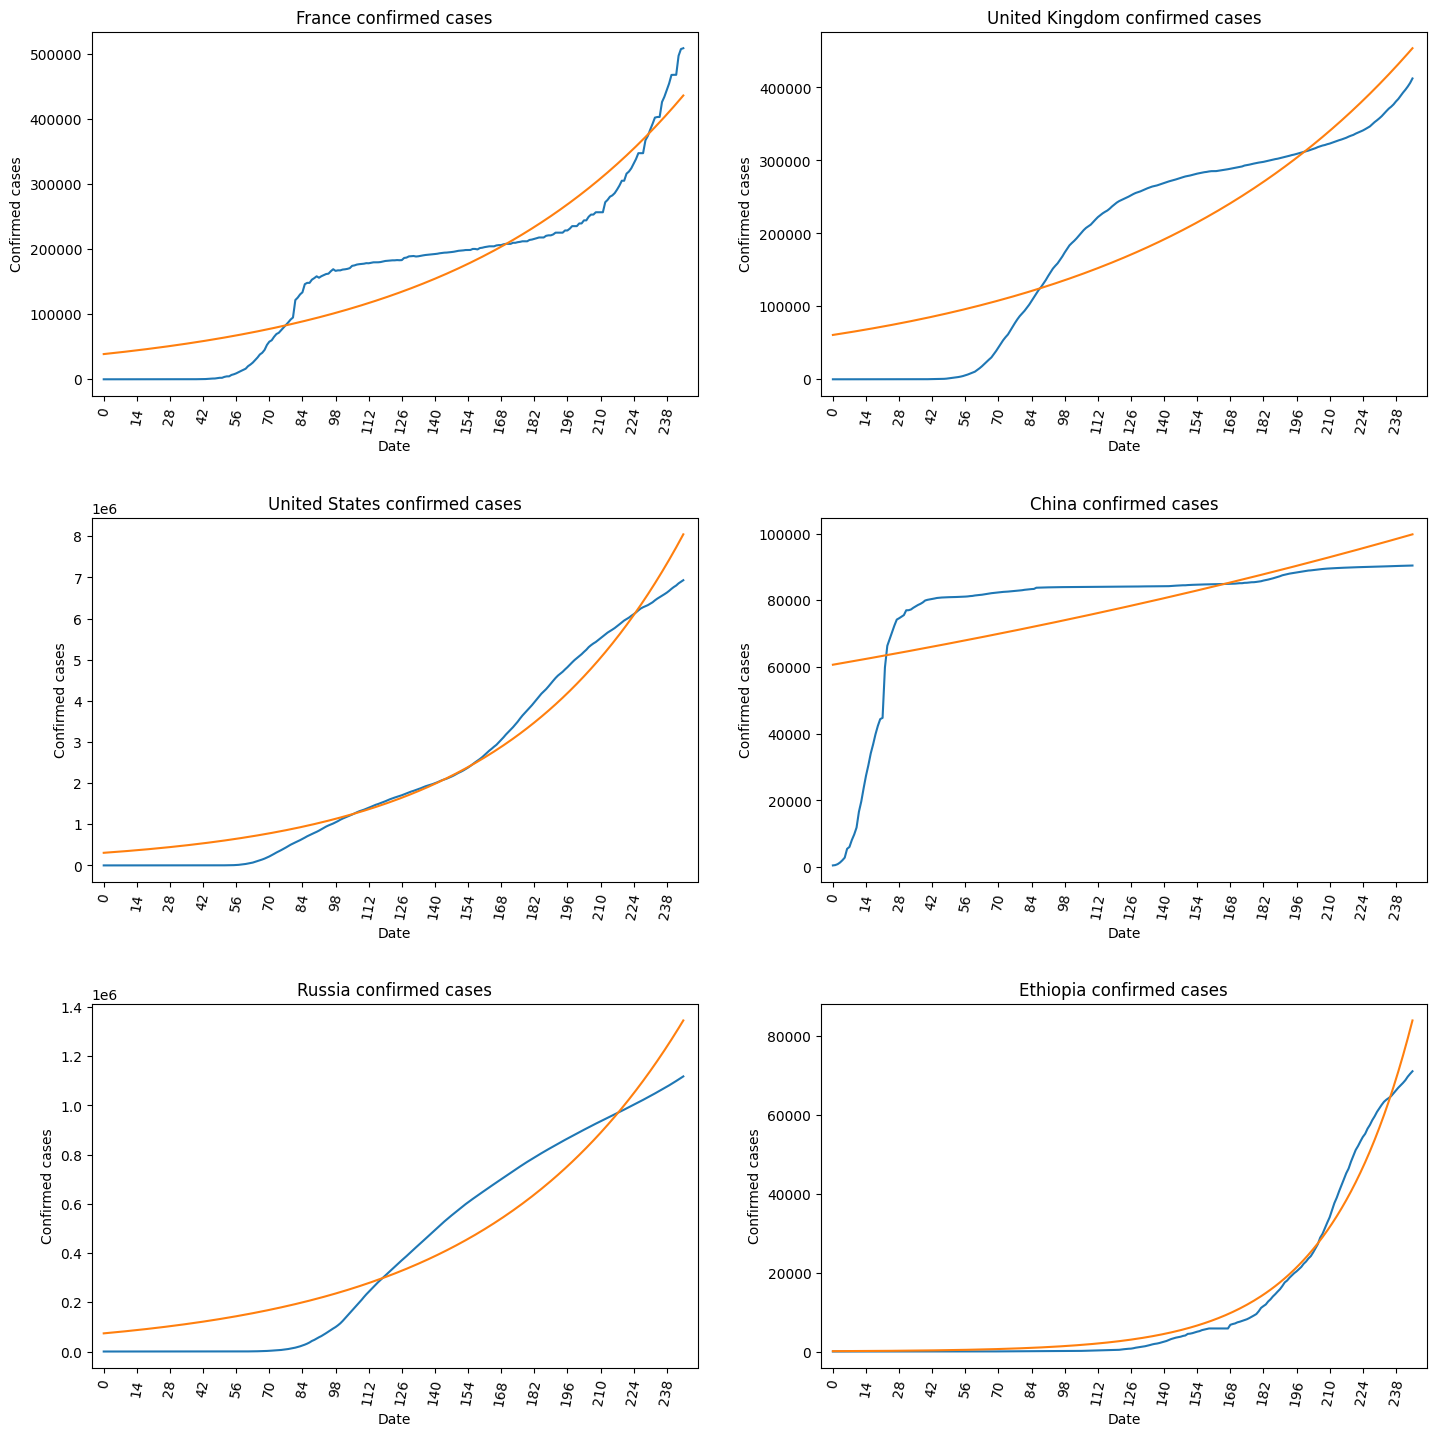

In [10]:
from scipy.optimize import curve_fit


countries = ['France', 'United Kingdom', 'United States', 'China', 'Russia', 'Ethiopia']

n = len(countries)
fig, axs = plt.subplots(math.ceil(n/2), 2, figsize=(15, 5 * math.ceil(n/2)))

def exponential(x, a, b):
    return np.exp(a * x + b)

for i, country in enumerate(countries):
    country_data = data[data['Country'] == country]
    country_data = country_data.drop(columns=['Country'])

    x = range(len(country_data.columns))
    y = country_data.values[0]

    popt, _ = curve_fit(exponential, x, y, maxfev=1000000)

    axs[i//2, i%2].plot(x, y)
    axs[i//2, i%2].plot(x, exponential(x, *popt))
    axs[i//2, i%2].set_title(f'{country} confirmed cases')
    axs[i//2, i%2].set_xlim(-5, len(x) + 5)
    axs[i//2, i%2].set_xlabel('Date')
    axs[i//2, i%2].set_ylabel('Confirmed cases')
    axs[i//2, i%2].tick_params(axis='x', rotation=80)
    axs[i//2, i%2].xaxis.set_major_locator(plt.MultipleLocator(14))
fig.tight_layout(pad=3.0)
plt.show()

As we can see, the exponential regression fits very well for Ethiopia and manages to do at least a decent fit for Russia and USA.